### simple simulation - no transaction fee, no etf expenses, no taxes, no dividends

# 초기 조건 / 데이터 임포트 / 벤치마크 계산

## 라이브러리 임포트 / 초기 조건 설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

In [3]:
risk_free_rate = 0
transaction_fee = 0
etf_expenses = 0
tax_rate = 0
initial_cash = 10000

In [4]:
current_date = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

In [5]:
strategies = []

## 데이터 임포트

In [6]:
df = pd.read_csv('/content/drive/MyDrive/quant_projects/momentum_strategies/SPY.csv')
closes = df.Close.to_numpy()
result_df = pd.DataFrame({'Date': df['Date']})

## 벤치마크 계산

In [7]:
benchmark_shares = initial_cash // closes[0]
benchmark = closes * benchmark_shares

# [전략1] 단일 12개월 look_back

## 계좌 정보 초기화

In [8]:
name = 'SPY_simulation_12'
df_12 = pd.read_csv('/content/drive/MyDrive/quant_projects/momentum_strategies/SPY.csv')

In [9]:
cash, account = [np.array([initial_cash] * len(closes), dtype=np.float64) for _ in range(2)]
upwards, positions, shares = [np.zeros(len(closes)) for _ in range(3)]

In [10]:
rebalancing_period = 1
look_backs = [12]

## 단일 look_back == 12

In [11]:
# look_backs 배열 도입 전 코드
# for i in range(12, len(closes)):
#   if (closes[i] - closes[i-12] >= risk_free_rate):
#     upwards[i] = True
#     if upwards[i-1]:
#       cash[i] = cash[i-1]
#       shares[i] = shares[i-1]
#       positions[i] = shares[i] * closes[i]
#     else:
#       shares[i] = cash[i-1] // closes[i]
#       positions[i] = shares[i] * closes[i]
#       cash[i] = cash[i-1] - positions[i]
#     account[i] = cash[i] + positions[i]
#   else:
#     upwards[i] = False
#     shares[i] = 0
#     positions[i] = 0
#     if upwards[i-1]:
#       cash[i] = cash[i-1] + shares[i-1] * closes[i]
#     else:
#       cash[i] = cash[i-1]
#     account[i] = cash[i] + positions[i] 
#   changes_12[i] = (closes[i] - closes[i-12]) / closes[i-12]

In [12]:
for i in range(max(look_backs), len(closes)):
  #조건에 만족하면 배당수익 기록 (보유 현금 증가로)
  # cash[i] = cash[i - 1] dividends[i] * shares[i - 1]
  look_back_upwards = [1 if closes[i] - closes[i-look_back] >= risk_free_rate else 0 for look_back in look_backs]
  upwards_ratio = sum(look_back_upwards) / len(look_back_upwards)
  upwards[i] = upwards_ratio
  shares[i] = (shares[i - 1] * closes[i] + cash[i - 1]) * upwards[i] // closes[i]
  shares_delta = shares[i] - shares[i - 1]
  if shares_delta == 0:
    # 보유
    cash[i] = cash[i - 1] #만약 지난달에 배당을 받았다면 주식:현금 비율이 변화하므로 리밸런싱 필요
    positions[i] = shares[i] * closes[i]
  else:
    # 추가 매수, 매도 공통
    cash[i] = cash[i - 1] - (shares_delta) * closes[i] #shares_delta가 양수면 매수, 음수면 매도
    positions[i] = closes[i] * shares[i]
    # 거래비용 기록
    if shares_delta < 0:
      # 매도로 인한 손익 기록
      pass
  account[i] = cash[i] + positions[i]

## 계좌 정보 업데이트 / csv로 출력

In [13]:
df_12['Upward'] = upwards.tolist()
df_12['Shares'] = shares.tolist()
df_12['Position'] = positions.tolist()
df_12['Cash'] = cash.tolist()
df_12['Account'] = account.tolist()
df_12['Benchmark'] = benchmark.tolist()

In [14]:
df_12.to_csv(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_{name}.csv')

In [15]:
strategies.append({"name":'12', "df":df_12})

# [전략2] 3/6/9/12개월 look-back

## 파일 임포트 / 계좌 정보 초기화

In [572]:
name = 'SPY_simulation_3_6_9_12'
df_3_6_9_12 = pd.read_csv('/content/drive/MyDrive/quant_projects/momentum_strategies/SPY.csv')

In [573]:
cash, account = [np.array([initial_cash] * len(closes), dtype=np.float64) for _ in range(2)]
upwards, positions, shares = [np.zeros(len(closes)) for _ in range(3)]

In [574]:
look_backs = [3,6,9,12]
rebalancing_period = 1 #in month

## look_backs 배열의 평균값만큼 지수 매수



In [575]:
# 코드 다듬기 전
# for i in range(max(look_backs), len(closes)):
#   #조건에 만족하면 배당수익 기록 (보유 현금 증가로)
#   # cash[i] += dividends[i] * shares[i - 1]
#   look_back_upwards = [1 if closes[i] - closes[i-look_back] >= risk_free_rate else 0 for look_back in look_backs]
#   upwards_ratio = sum(look_back_upwards) / len(look_back_upwards)
#   upwards[i] = upwards_ratio
#   shares[i] = (shares[i - 1] * closes[i] + cash[i - 1]) * upwards[i] // closes[i]
#   shares_delta = shares[i] - shares[i - 1]
#   if shares_delta > 0:
#     # 추가 매수
#     cash[i] = cash[i - 1] - (shares_delta) * closes[i]
#     positions[i] = closes[i] * shares[i]
#     # 거래비용 기록
#   elif shares_delta < 0:
#     # 매도
#     cash[i] = cash[i - 1] - (shares_delta) * closes[i]
#     positions[i] = closes[i] * shares[i]
#     # 손익 기록, 거래비용 기록
#   else:
#     # 보유
#     cash[i] = cash[i - 1]
#     positions[i] = shares[i] * closes[i]    
#   account[i] = cash[i] + positions[i]

In [576]:
for i in range(max(look_backs), len(closes)):
  #조건에 만족하면 배당수익 기록 (보유 현금 증가로)
  # cash[i] = cash[i - 1] dividends[i] * shares[i - 1]
  look_back_upwards = [1 if closes[i] - closes[i-look_back] >= risk_free_rate else 0 for look_back in look_backs]
  upwards_ratio = sum(look_back_upwards) / len(look_back_upwards)
  upwards[i] = upwards_ratio
  shares[i] = (shares[i - 1] * closes[i] + cash[i - 1]) * upwards[i] // closes[i]
  shares_delta = shares[i] - shares[i - 1]
  if shares_delta == 0:
    # 보유
    cash[i] = cash[i - 1] #만약 지난달에 배당을 받았다면 주식:현금 비율이 변화하므로 리밸런싱 필요
    positions[i] = shares[i] * closes[i]
  else:
    # 추가 매수, 매도 공통
    cash[i] = cash[i - 1] - (shares_delta) * closes[i] #shares_delta가 양수면 매수, 음수면 매도
    positions[i] = closes[i] * shares[i]
    # 거래비용 기록
    if shares_delta < 0:
      # 매도로 인한 손익 기록
      pass
  account[i] = cash[i] + positions[i]

## 계좌 정보 업데이트 / csv로 출력

In [577]:
df_3_6_9_12['Upward'] = upwards.tolist()
df_3_6_9_12['Shares'] = shares.tolist()
df_3_6_9_12['Position'] = positions.tolist()
df_3_6_9_12['Cash'] = cash.tolist()
df_3_6_9_12['Account'] = account.tolist()
df_3_6_9_12['Benchmark'] = benchmark.tolist()

In [578]:
df_3_6_9_12.to_csv(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_{name}.csv')

In [579]:
strategies.append({"name":'3_6_9_12', "df":df_3_6_9_12})

# [전략3] 3/6/12개월 look-back

## 파일 임포트 / 계좌 정보 초기화

In [580]:
name = 'SPY_simulation_3_6_12'
df_3_6_12 = pd.read_csv('/content/drive/MyDrive/quant_projects/momentum_strategies/SPY.csv')

In [581]:
cash, account = [np.array([initial_cash] * len(closes), dtype=np.float64) for _ in range(2)]
upwards, positions, shares = [np.zeros(len(closes)) for _ in range(3)]

In [582]:
look_backs = [3,6,12]
rebalancing_period = 1 #in month

## look_backs 배열의 평균값만큼 지수 매수



In [583]:
# 코드 다듬기 전
# for i in range(max(look_backs), len(closes)):
#   #조건에 만족하면 배당수익 기록 (보유 현금 증가로)
#   # cash[i] += dividends[i] * shares[i - 1]
#   look_back_upwards = [1 if closes[i] - closes[i-look_back] >= risk_free_rate else 0 for look_back in look_backs]
#   upwards_ratio = sum(look_back_upwards) / len(look_back_upwards)
#   upwards[i] = upwards_ratio
#   shares[i] = (shares[i - 1] * closes[i] + cash[i - 1]) * upwards[i] // closes[i]
#   shares_delta = shares[i] - shares[i - 1]
#   if shares_delta > 0:
#     # 추가 매수
#     cash[i] = cash[i - 1] - (shares_delta) * closes[i]
#     positions[i] = closes[i] * shares[i]
#     # 거래비용 기록
#   elif shares_delta < 0:
#     # 매도
#     cash[i] = cash[i - 1] - (shares_delta) * closes[i]
#     positions[i] = closes[i] * shares[i]
#     # 손익 기록, 거래비용 기록
#   else:
#     # 보유
#     cash[i] = cash[i - 1]
#     positions[i] = shares[i] * closes[i]    
#   account[i] = cash[i] + positions[i]

In [584]:
for i in range(max(look_backs), len(closes)):
  #조건에 만족하면 배당수익 기록 (보유 현금 증가로)
  # cash[i] = cash[i - 1] dividends[i] * shares[i - 1]
  look_back_upwards = [1 if closes[i] - closes[i-look_back] >= risk_free_rate else 0 for look_back in look_backs]
  upwards_ratio = sum(look_back_upwards) / len(look_back_upwards)
  upwards[i] = upwards_ratio
  shares[i] = (shares[i - 1] * closes[i] + cash[i - 1]) * upwards[i] // closes[i]
  shares_delta = shares[i] - shares[i - 1]
  if shares_delta == 0:
    # 보유
    cash[i] = cash[i - 1] #만약 지난달에 배당을 받았다면 주식:현금 비율이 변화하므로 리밸런싱 필요
    positions[i] = shares[i] * closes[i]
  else:
    # 추가 매수, 매도 공통
    cash[i] = cash[i - 1] - (shares_delta) * closes[i] #shares_delta가 양수면 매수, 음수면 매도
    positions[i] = closes[i] * shares[i]
    # 거래비용 기록
    if shares_delta < 0:
      # 매도로 인한 손익 기록
      pass
  account[i] = cash[i] + positions[i]

## 계좌 정보 업데이트 / csv로 출력

In [585]:
df_3_6_12['Upward'] = upwards.tolist()
df_3_6_12['Shares'] = shares.tolist()
df_3_6_12['Position'] = positions.tolist()
df_3_6_12['Cash'] = cash.tolist()
df_3_6_12['Account'] = account.tolist()
df_3_6_12['Benchmark'] = benchmark.tolist()

In [586]:
df_3_6_12.to_csv(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_{name}.csv')

In [587]:
strategies.append({"name":"3_6_12", "df":df_3_6_12})

# [전략4] 3/12개월 look-back

## 파일 임포트 / 계좌 정보 초기화

In [588]:
name = 'SPY_simulation_3_12'
df_3_12 = pd.read_csv('/content/drive/MyDrive/quant_projects/momentum_strategies/SPY.csv')

In [589]:
cash, account = [np.array([initial_cash] * len(closes), dtype=np.float64) for _ in range(2)]
upwards, positions, shares = [np.zeros(len(closes)) for _ in range(3)]

In [590]:
look_backs = [3,12]
rebalancing_period = 1 #in month

## look_backs 배열의 평균값만큼 지수 매수



In [591]:
# 코드 다듬기 전
# for i in range(max(look_backs), len(closes)):
#   #조건에 만족하면 배당수익 기록 (보유 현금 증가로)
#   # cash[i] += dividends[i] * shares[i - 1]
#   look_back_upwards = [1 if closes[i] - closes[i-look_back] >= risk_free_rate else 0 for look_back in look_backs]
#   upwards_ratio = sum(look_back_upwards) / len(look_back_upwards)
#   upwards[i] = upwards_ratio
#   shares[i] = (shares[i - 1] * closes[i] + cash[i - 1]) * upwards[i] // closes[i]
#   shares_delta = shares[i] - shares[i - 1]
#   if shares_delta > 0:
#     # 추가 매수
#     cash[i] = cash[i - 1] - (shares_delta) * closes[i]
#     positions[i] = closes[i] * shares[i]
#     # 거래비용 기록
#   elif shares_delta < 0:
#     # 매도
#     cash[i] = cash[i - 1] - (shares_delta) * closes[i]
#     positions[i] = closes[i] * shares[i]
#     # 손익 기록, 거래비용 기록
#   else:
#     # 보유
#     cash[i] = cash[i - 1]
#     positions[i] = shares[i] * closes[i]    
#   account[i] = cash[i] + positions[i]

In [592]:
for i in range(max(look_backs), len(closes)):
  #조건에 만족하면 배당수익 기록 (보유 현금 증가로)
  # cash[i] = cash[i - 1] dividends[i] * shares[i - 1]
  look_back_upwards = [1 if closes[i] - closes[i-look_back] >= risk_free_rate else 0 for look_back in look_backs]
  upwards_ratio = sum(look_back_upwards) / len(look_back_upwards)
  upwards[i] = upwards_ratio
  shares[i] = (shares[i - 1] * closes[i] + cash[i - 1]) * upwards[i] // closes[i]
  shares_delta = shares[i] - shares[i - 1]
  if shares_delta == 0:
    # 보유
    cash[i] = cash[i - 1] #만약 지난달에 배당을 받았다면 주식:현금 비율이 변화하므로 리밸런싱 필요
    positions[i] = shares[i] * closes[i]
  else:
    # 추가 매수, 매도 공통
    cash[i] = cash[i - 1] - (shares_delta) * closes[i] #shares_delta가 양수면 매수, 음수면 매도
    positions[i] = closes[i] * shares[i]
    # 거래비용 기록
    if shares_delta < 0:
      # 매도로 인한 손익 기록
      pass
  account[i] = cash[i] + positions[i]

## 계좌 정보 업데이트 / csv로 출력

In [593]:
df_3_12['Upward'] = upwards.tolist()
df_3_12['Shares'] = shares.tolist()
df_3_12['Position'] = positions.tolist()
df_3_12['Cash'] = cash.tolist()
df_3_12['Account'] = account.tolist()
df_3_12['Benchmark'] = benchmark.tolist()

In [594]:
df_3_12.to_csv(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_{name}.csv')

In [595]:
strategies.append({"name":"3_12", "df":df_3_12})

# [전략5] 단일 12개월 look_back, 3개월 리밸런싱

## 계좌 정보 초기화

In [16]:
name = 'SPY_simulation_3:12'
df_3to12 = pd.read_csv('/content/drive/MyDrive/quant_projects/momentum_strategies/SPY.csv')

In [17]:
cash, account = [np.array([initial_cash] * len(closes), dtype=np.float64) for _ in range(2)]
upwards, positions, shares = [np.zeros(len(closes)) for _ in range(3)]

In [18]:
rebalancing_period = 3
look_backs = [12]

## 단일 look_back == 12

In [19]:
for i in range(max(look_backs), len(closes)):
  #조건에 만족하면 배당수익 기록 (보유 현금 증가로)
  # cash[i] = cash[i - rebalancing_period] dividends[i] * shares[i - rebalancing_period]
  if i % rebalancing_period == 0:
    look_back_upwards = [1 if closes[i] - closes[i-look_back] >= risk_free_rate else 0 for look_back in look_backs]
    upwards_ratio = sum(look_back_upwards) / len(look_back_upwards)
    upwards[i] = upwards_ratio
    shares[i] = (shares[i - 1] * closes[i] + cash[i - 1]) * upwards[i] // closes[i]
    shares_delta = shares[i] - shares[i - 1]
    if shares_delta == 0:
      # 보유
      cash[i] = cash[i - 1] #만약 지난달에 배당을 받았다면 주식:현금 비율이 변화하므로 리밸런싱 필요
      positions[i] = shares[i] * closes[i]
    else:
      # 추가 매수, 매도 공통
      cash[i] = cash[i - 1] - (shares_delta) * closes[i] #shares_delta가 양수면 매수, 음수면 매도
      positions[i] = closes[i] * shares[i]
      # 거래비용 기록
      if shares_delta < 0:
        # 매도로 인한 손익 기록
        pass
  else:
    cash[i] = cash[i-1]
    shares[i] = shares[i-1]
    positions[i] = shares[i] * closes[i]
  account[i] = cash[i] + positions[i]

## 계좌 정보 업데이트 / csv로 출력

In [20]:
df_3to12['Upward'] = upwards.tolist()
df_3to12['Shares'] = shares.tolist()
df_3to12['Position'] = positions.tolist()
df_3to12['Cash'] = cash.tolist()
df_3to12['Account'] = account.tolist()
df_3to12['Benchmark'] = benchmark.tolist()

In [21]:
df_3to12.to_csv(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_{name}.csv')

In [22]:
strategies.append({"name":'3:12', "df":df_3to12})

# [전략6] 단일 12개월 look_back, 2개월 리밸런싱

## 계좌 정보 초기화

In [38]:
name = 'SPY_simulation_2:12'
df_2to12 = pd.read_csv('/content/drive/MyDrive/quant_projects/momentum_strategies/SPY.csv')

In [39]:
cash, account = [np.array([initial_cash] * len(closes), dtype=np.float64) for _ in range(2)]
upwards, positions, shares = [np.zeros(len(closes)) for _ in range(3)]

In [40]:
rebalancing_period = 2
look_backs = [12]

## 단일 look_back == 12

In [41]:
for i in range(max(look_backs), len(closes)):
  #조건에 만족하면 배당수익 기록 (보유 현금 증가로)
  # cash[i] = cash[i - rebalancing_period] dividends[i] * shares[i - rebalancing_period]
  if i % rebalancing_period == 0:
    look_back_upwards = [1 if closes[i] - closes[i-look_back] >= risk_free_rate else 0 for look_back in look_backs]
    upwards_ratio = sum(look_back_upwards) / len(look_back_upwards)
    upwards[i] = upwards_ratio
    shares[i] = (shares[i - 1] * closes[i] + cash[i - 1]) * upwards[i] // closes[i]
    shares_delta = shares[i] - shares[i - 1]
    if shares_delta == 0:
      # 보유
      cash[i] = cash[i - 1] #만약 지난달에 배당을 받았다면 주식:현금 비율이 변화하므로 리밸런싱 필요
      positions[i] = shares[i] * closes[i]
    else:
      # 추가 매수, 매도 공통
      cash[i] = cash[i - 1] - (shares_delta) * closes[i] #shares_delta가 양수면 매수, 음수면 매도
      positions[i] = closes[i] * shares[i]
      # 거래비용 기록
      if shares_delta < 0:
        # 매도로 인한 손익 기록
        pass
  else:
    cash[i] = cash[i-1]
    shares[i] = shares[i-1]
    positions[i] = shares[i] * closes[i]
  account[i] = cash[i] + positions[i]

## 계좌 정보 업데이트 / csv로 출력

In [42]:
df_2to12['Upward'] = upwards.tolist()
df_2to12['Shares'] = shares.tolist()
df_2to12['Position'] = positions.tolist()
df_2to12['Cash'] = cash.tolist()
df_2to12['Account'] = account.tolist()
df_2to12['Benchmark'] = benchmark.tolist()

In [43]:
df_2to12.to_csv(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_{name}.csv')

In [44]:
strategies.append({"name":'2:12', "df":df_2to12})

# [전략7] 단일 12개월 look_back, 6개월 리밸런싱

## 계좌 정보 초기화

In [49]:
name = 'SPY_simulation_6:12'
df_6to12 = pd.read_csv('/content/drive/MyDrive/quant_projects/momentum_strategies/SPY.csv')

In [50]:
cash, account = [np.array([initial_cash] * len(closes), dtype=np.float64) for _ in range(2)]
upwards, positions, shares = [np.zeros(len(closes)) for _ in range(3)]

In [51]:
rebalancing_period = 6
look_backs = [12]

## 단일 look_back == 12

In [52]:
for i in range(max(look_backs), len(closes)):
  #조건에 만족하면 배당수익 기록 (보유 현금 증가로)
  # cash[i] = cash[i - rebalancing_period] dividends[i] * shares[i - rebalancing_period]
  if i % rebalancing_period == 0:
    look_back_upwards = [1 if closes[i] - closes[i-look_back] >= risk_free_rate else 0 for look_back in look_backs]
    upwards_ratio = sum(look_back_upwards) / len(look_back_upwards)
    upwards[i] = upwards_ratio
    shares[i] = (shares[i - 1] * closes[i] + cash[i - 1]) * upwards[i] // closes[i]
    shares_delta = shares[i] - shares[i - 1]
    if shares_delta == 0:
      # 보유
      cash[i] = cash[i - 1] #만약 지난달에 배당을 받았다면 주식:현금 비율이 변화하므로 리밸런싱 필요
      positions[i] = shares[i] * closes[i]
    else:
      # 추가 매수, 매도 공통
      cash[i] = cash[i - 1] - (shares_delta) * closes[i] #shares_delta가 양수면 매수, 음수면 매도
      positions[i] = closes[i] * shares[i]
      # 거래비용 기록
      if shares_delta < 0:
        # 매도로 인한 손익 기록
        pass
  else:
    cash[i] = cash[i-1]
    shares[i] = shares[i-1]
    positions[i] = shares[i] * closes[i]
  account[i] = cash[i] + positions[i]

## 계좌 정보 업데이트 / csv로 출력

In [53]:
df_6to12['Upward'] = upwards.tolist()
df_6to12['Shares'] = shares.tolist()
df_6to12['Position'] = positions.tolist()
df_6to12['Cash'] = cash.tolist()
df_6to12['Account'] = account.tolist()
df_6to12['Benchmark'] = benchmark.tolist()

In [54]:
df_6to12.to_csv(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_{name}.csv')

In [55]:
strategies.append({"name":'6:12', "df":df_6to12})

# 결과 출력

## csv / jpg 출력

In [56]:
result_df['Benchmark'] = benchmark.tolist()

In [57]:
for strategy in strategies:
  result_df[strategy['name']] = strategy['df']['Account'].tolist()

In [58]:
result_df.head()

,Date,Benchmark,12,3:12,2:12,6:12
0,1993-02-01,9991.40625,10000.0,10000.0,10000.0,10000.0
1,1993-03-01,10167.18750,10000.0,10000.0,10000.0,10000.0
2,1993-04-01,9907.03125,10000.0,10000.0,10000.0,10000.0
3,1993-05-01,10174.21875,10000.0,10000.0,10000.0,10000.0
4,1993-06-01,10139.06250,10000.0,10000.0,10000.0,10000.0


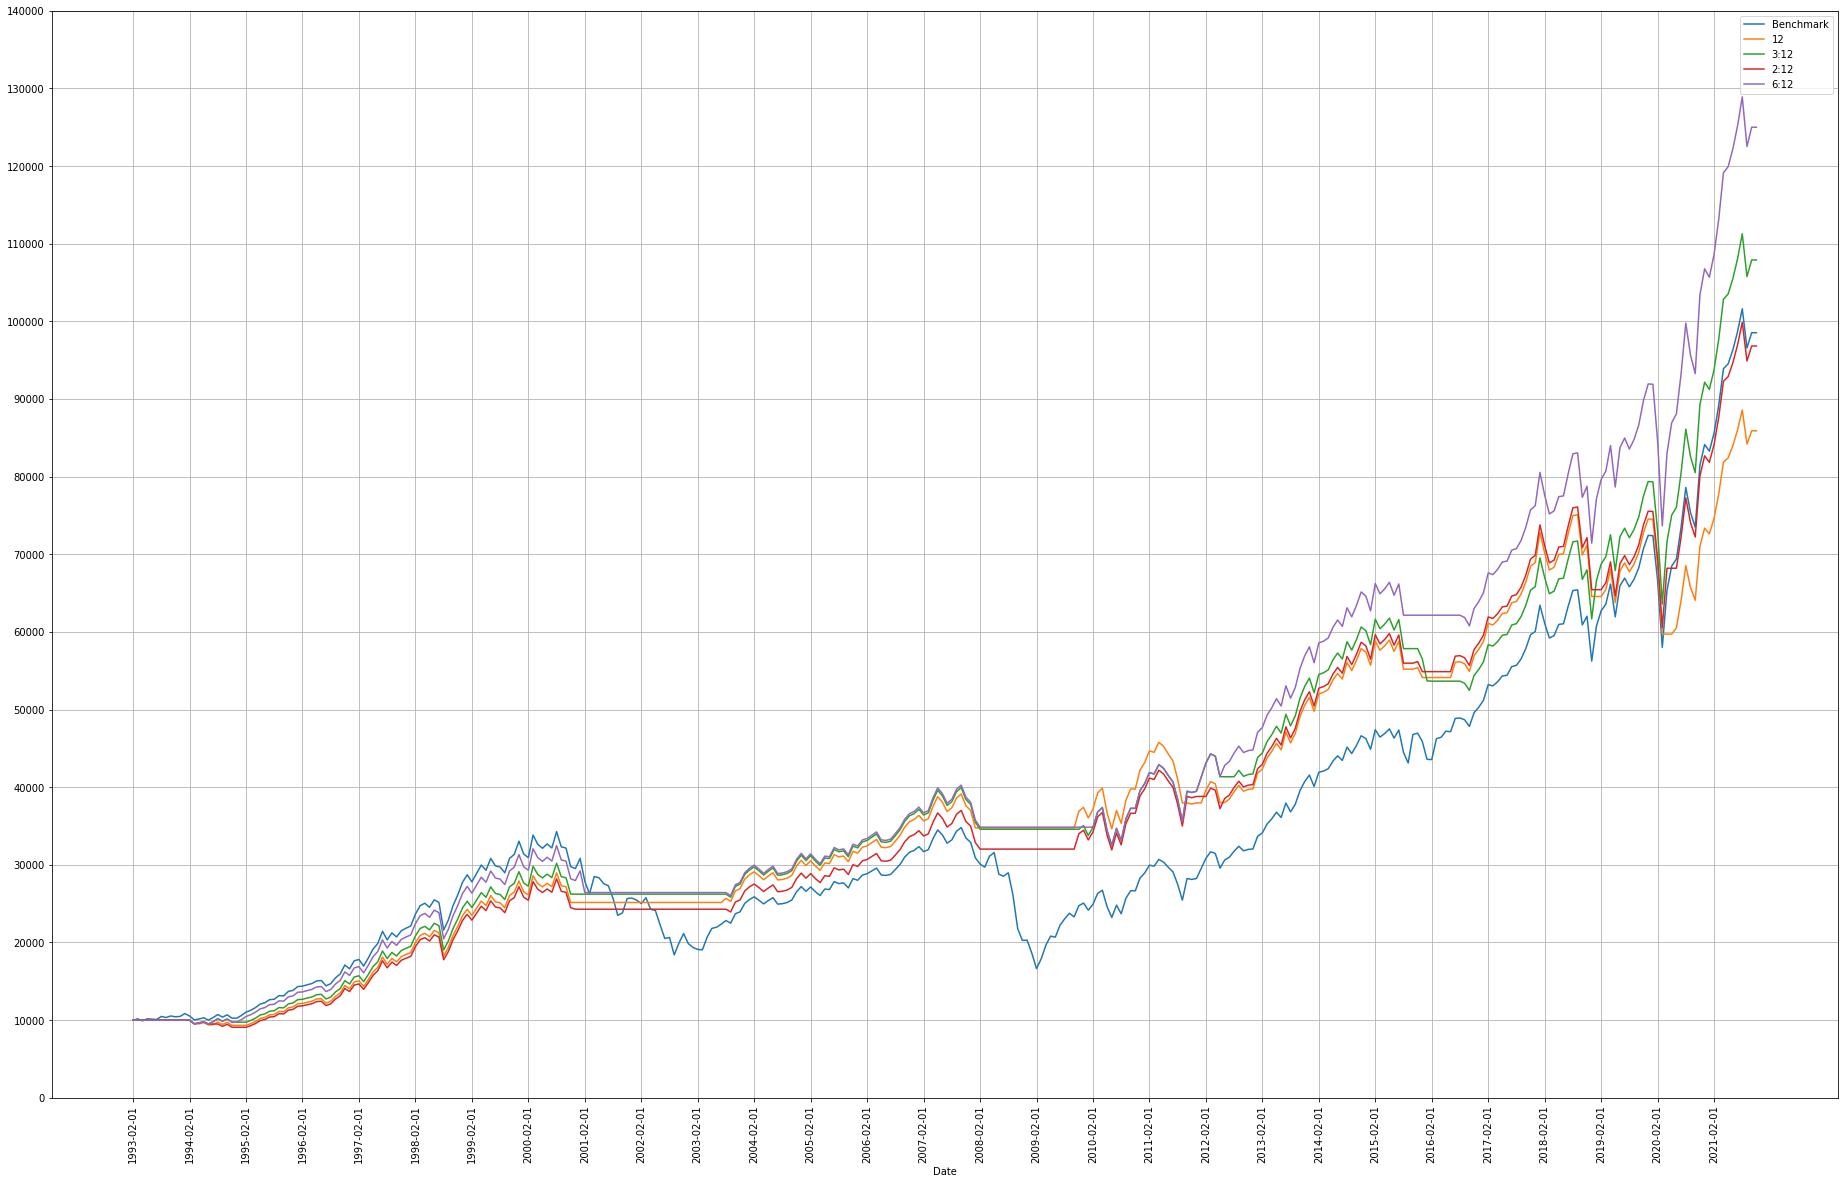

In [63]:
result_df.to_csv(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_result.csv')

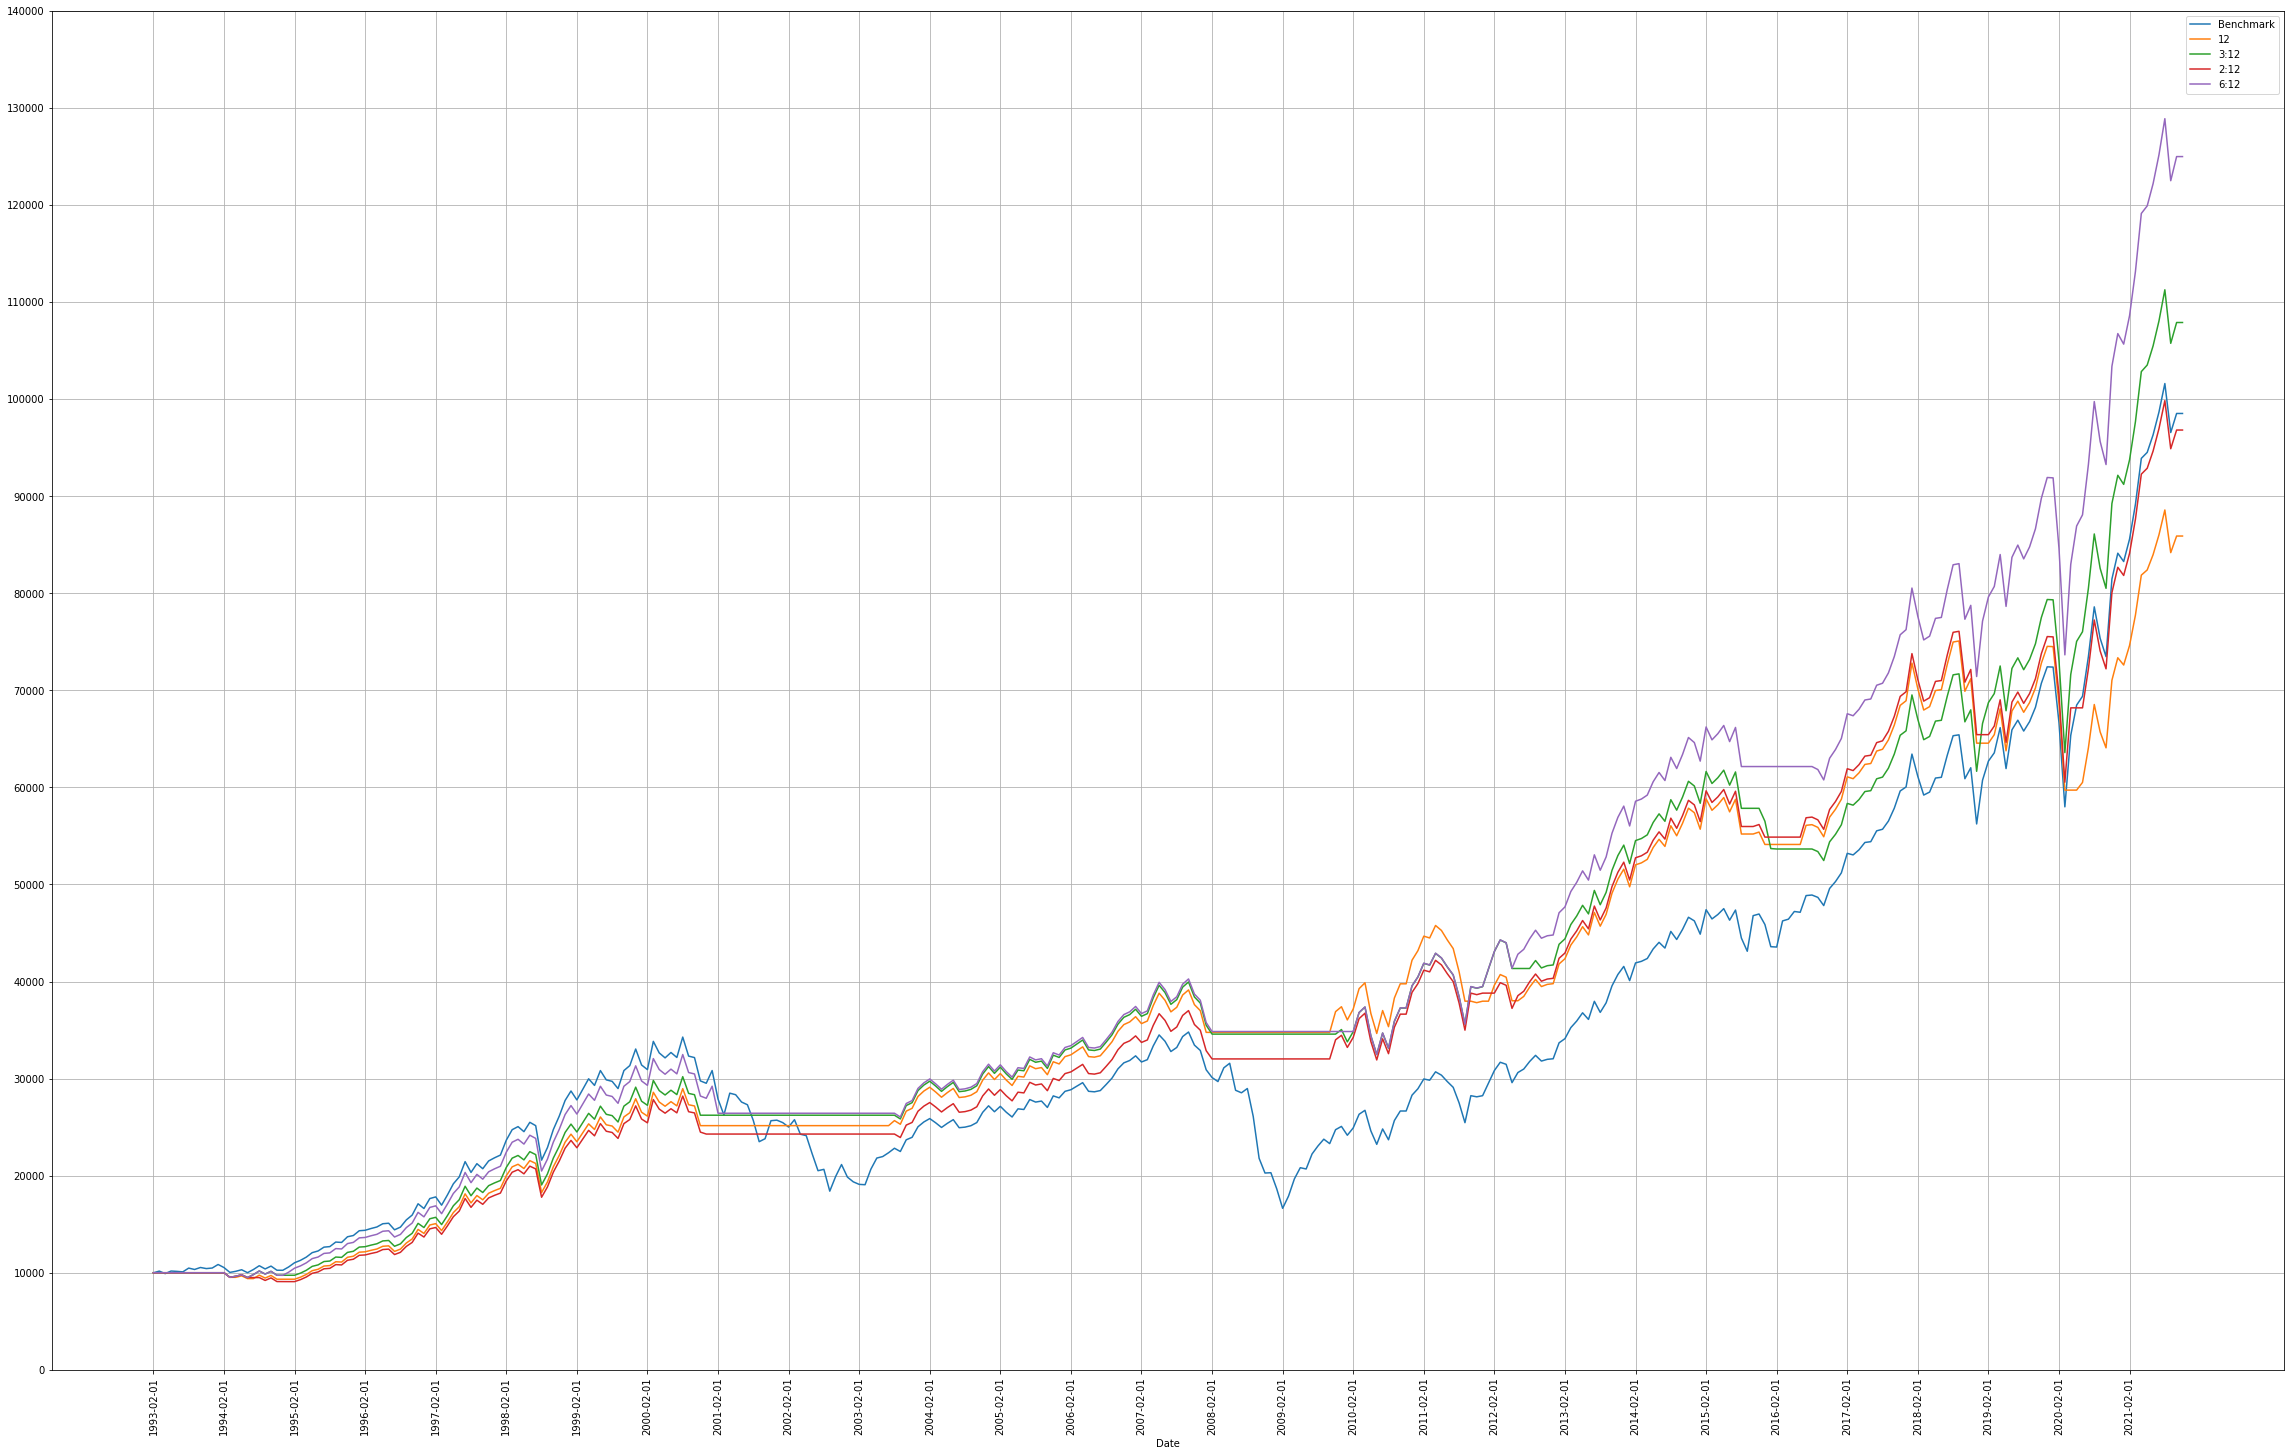

In [64]:
chart = result_df.plot.line(x='Date', grid=True, figsize=(40,25), xticks=np.arange(0, 346, 12), yticks=np.arange(0, 150000, 10000))
chart.tick_params(axis='x', rotation=90)
chart.figure.savefig(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_result.jpg')